In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

The beginning of this notebook is somewhat similar to `viz_segment6.ipynb` because it loads up the turning points and the hash codes.

In [3]:
# Load the hash_master file
hash_df = pd.read_csv('../data/osstate/routes_hashes/hash_master.hashb', header=None, names=['wpf', 'wpt', 'hash'])
print(f"There are {len(hash_df)} rows")
hash_df.head()

There are 19466 rows


,wpf,wpt,hash
0,BdqjF4kdoWuF,FEQqm0pwCiHB,06355708377841511e89a4d57999c81ca8f7ac7d3ad371...
1,fsfzvUfF161g,g8jG0jNTYLWh,8635571817e841751e89a4c579ddc89c88f6a8753a1351...
2,TizH2bRw7vGs,xzpBLhCfzUsF,8225571897e841751f09a4c779dd889c88f6a8753a1211...
3,EThpIE3IBmHj,GPvokn2TQRgr,f044a2d69c87bf3e57775a2ab6f424ea55bc43031d2c8e...
4,uQXbsh0Pt5dR,Hoalau7wsbpF,f024335694c72f3457537aa637f404ea55bcc013192c8a...


In [4]:
hash_unique = hash_df['hash'].unique()
print('Number of unique hashes:', len(hash_unique))

Number of unique hashes: 470


In [5]:
# Rank the hashes by the number of times they appear
hash_counts = hash_df['hash'].value_counts()
hash_counts = hash_counts.sort_values(ascending=False)
hash_counts.head(10)


hash
f04432569487bf3e57775a2ab7f404ea55bcc1131d2c8ebaeadfc8e121934e9e8663f26847fdcc27c9cfeee8a76abeec7e39d55c7973cc99467abfc5_6f5    1776
8635570817e841751e89a4c579ddc89c88f6a8753a535102254d648c7c5e0511d53e836fdac2f7e7f287523e991367faccc70bc100d2749b261d10da_8b3     691
8225571897e041751f09a4c779dd889c88f6a8753a101102254d64907c5e0511d56ec36fdec2e7e7f287d63e991b77facc470bc029d2749b061f12db_8f3     575
8635571817e841751e89a4c579ddc89c88f6a8753a135102254d649c7c5e0511d53ec36fdec2f7e7f287d23e991b77faccc70bc109d2749b261d10da_8b3     552
8225571a97c041751f49a4c779dd8cfc98fee87538101382255d64907f5a0413d76ed36bdef2e7a7e287d63e994b76face470b5029d25c9b061e12db_8f3     552
8225571897e841751f09a4c779dd889c88f6a8753a121102254d64907c5e0511d56ec36fdec2e7e7f287d63e991b77facc470bc029d2749b061f12db_8f3     527
06355718176841711e89a4c559ddc89ca8f6a8753a535102254d649c7e5e1511d53e836fdac2f7e7f287523e991367faccc70bc100d2749b261d10da_8b3     463
a225571e97c043751741a4877ddd8cfcd8bee8773810129225dd64907d5a0413

In [6]:
# Load the waypoints_master file
wp_df = pd.read_csv('../data/osstate/waypoints_master.csv')
wp_df.head()

,ident,lat,lon
0,H882U2Xn5VOd,50.404884,-98.626030
1,P8ToOqoOwy3c,32.375521,130.663520
2,oZYSGKN80id2,41.086054,-77.855456
3,uPuRzZYavxw1,40.908554,-78.007263
4,lEf9PODPqPxe,40.573301,-78.509674


# Stitching for CONUS

In [7]:
region = 'conus'
def get_region_bounds(region: str) -> tuple:
    # Get the geographical boundaries for the map 
    if region=='conus':
        # Contiguous United States
        lat_bounds = [23, 51]
        lon_bounds = [-130, -65]
    elif region=='europe':
        # Europe, from Portugal to Greece, not including Russia
        lat_bounds = [34, 72]        
        lon_bounds = [-32, 40]
    else:
        raise ValueError(f"Region {region} not recognized. Use 'conus' or 'europe'.")
    
    return lat_bounds, lon_bounds

lat_bounds, lon_bounds = get_region_bounds(region)

/tmp/ipykernel_14102/3958555002.py:53: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  wpf_x, wpf_y = transform(inProj, outProj, wpf_lons, wpf_lats, always_xy=True)
/tmp/ipykernel_14102/3958555002.py:54: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  wpt_x, wpt_y = transform(inProj, outProj, wpt_lons, wpt_lats, always_xy=True)


Expected seg_start: 617029.6375266847
Expected seg_end: 3000091.5016088816
Result:  11 -1 -1 44
For debugging: sm_start:  [1939580.774578999, 2285195.291627705]
For debugging: ending_points[sm_e] (holds if last element is not -1) 3000091.5016088816
sm_end:  [88558.57396891614, 783891.385730682]


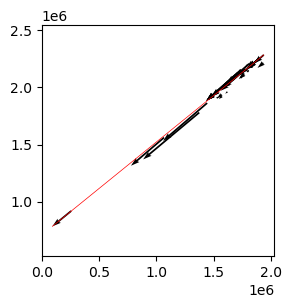

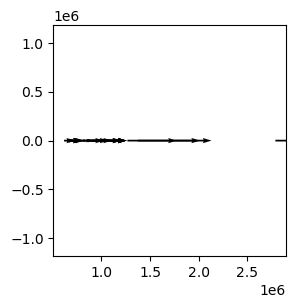

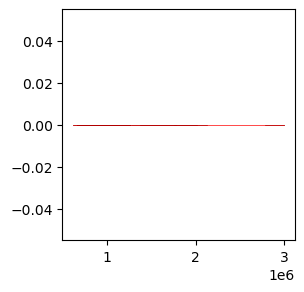

In [23]:
from tqdm import tqdm
from pyproj import Proj, transform
from stitcher import stitch

import warnings
warnings.simplefilter("error", RuntimeWarning)

color_codes = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def get_flow(hash_no: int, hash_df: pd.DataFrame, wp_df: pd.DataFrame, region = 'conus', n_segments_to_sample = 50) -> None:

    # Get the top n_plots hash values
    hash_values = hash_counts.head(128).index

    # Get the hash code corresponding to the hash_no
    hash_value = hash_values[hash_no]

    # Get the data frame for this hash value
    hash_df_i = hash_df[hash_df['hash'] == hash_value]

    # If hash_df_i has more than 20 rows, sample 20 rows
    
    if len(hash_df_i) > n_segments_to_sample:
        hash_df_i = hash_df_i.sample(n_segments_to_sample)

    # Get the waypoints
    wpf = hash_df_i['wpf'].values
    wpt = hash_df_i['wpt'].values

    wpf_lats = np.zeros(len(wpf))
    wpf_lons = np.zeros(len(wpf))
    wpt_lats = np.zeros(len(wpt))
    wpt_lons = np.zeros(len(wpt))

    # Get the latitude and longitude of the waypoints
    for j in range(len(wpf)):
        wpf_lon = wp_df[wp_df['ident'] == wpf[j]]['lon'].values[0]
        wpf_lat = wp_df[wp_df['ident'] == wpf[j]]['lat'].values[0]
        wpt_lon = wp_df[wp_df['ident'] == wpt[j]]['lon'].values[0]
        wpt_lat = wp_df[wp_df['ident'] == wpt[j]]['lat'].values[0]
        wpf_lats[j] = wpf_lat
        wpf_lons[j] = wpf_lon
        wpt_lats[j] = wpt_lat
        wpt_lons[j] = wpt_lon

    # Convert latitude and longitude to x and y using pyproj
    inProj = Proj('epsg:4326')
    outProj = Proj('epsg:5070')
    # transformer = Transformer.from_crs('epsg:4326', 'epsg:5070')
    # wpf_x, wpf_y = transformer.transform(wpf_lons, wpf_lats)
    # wpt_x, wpt_y = transformer.transform(wpt_lons, wpt_lats)
    # PyProj1 is deprecated
    wpf_x, wpf_y = transform(inProj, outProj, wpf_lons, wpf_lats, always_xy=True)
    wpt_x, wpt_y = transform(inProj, outProj, wpt_lons, wpt_lats, always_xy=True)

    wpft_length = np.sqrt((wpt_x - wpf_x)**2 + (wpt_y - wpf_y)**2)

    # Pick the longest segment to calculate the flow angle and reorient the segments
    longest_segment_index = np.argmax(wpft_length)

    # INVERT THE SEGMENTS SO THAT ALL SEGMENTS FLOW IN THE SAME DIRECTION WITH THE LONGEST SEGMENT
    segment_x = wpt_x - wpf_x
    segment_y = wpt_y - wpf_y

    segment_longest_x = segment_x[longest_segment_index]
    segment_longest_y = segment_y[longest_segment_index]

    # We take the sign of the dot product between each segment and the longest segment
    # If the sign is positive, the segment is in the same direction as the longest segment
    # If the sign is negative, the segment is in the opposite direction as the longest segment
    dp = segment_x * segment_longest_x + segment_y * segment_longest_y
    dp_sign = np.sign(dp)
    # Where dp_sign is 0, we set it to 1
    dp_sign[dp_sign == 0] = 1
    segment_x = segment_x * dp_sign
    segment_y = segment_y * dp_sign

    wpt_x = (wpf_x + segment_x).copy()
    wpt_y = (wpf_y + segment_y).copy()

    # FLOW ANGLE REORIENTATION
    flow_rotation_center = np.array([wpf_x[longest_segment_index], wpf_y[longest_segment_index]])
    flow_angle = -np.arctan2(wpt_y[longest_segment_index] - wpf_y[longest_segment_index], wpt_x[longest_segment_index] - wpf_x[longest_segment_index])
    starting_points = (wpf_x - flow_rotation_center[0]) * np.cos(flow_angle) - (wpf_y - flow_rotation_center[1]) * np.sin(flow_angle) + flow_rotation_center[0]
    #starting_points_y = (wpf_x - flow_rotation_center[0]) * np.sin(flow_angle) + (wpf_y - flow_rotation_center[1]) * np.cos(flow_angle) + flow_rotation_center[1]
    ending_points = (wpt_x - flow_rotation_center[0]) * np.cos(flow_angle) - (wpt_y - flow_rotation_center[1]) * np.sin(flow_angle) + flow_rotation_center[0]
    #ending_points_y = (wpt_x - flow_rotation_center[0]) * np.sin(flow_angle) + (wpt_y - flow_rotation_center[1]) * np.cos(flow_angle) + flow_rotation_center[1]
    # ending_points = wpf_x + (wpt_x - wpf_x) * np.cos(flow_angle) - (wpt_y - wpf_y) * np.sin(flow_angle)

    # For each pair of starting_point and ending_point, swap them if the starting_point is greater than the ending_point
    for i in range(len(starting_points)):
        if starting_points[i] > ending_points[i]:
            starting_points[i], ending_points[i] = ending_points[i], starting_points[i]

    # STITCH THE SEGMENTS USING STITCHER
    # ss: start in the starting_points, se: start in the ending_points, es: end in the starting_points, ee: end in the ending_points
    sm_ss, sm_se, sm_es, sm_ee = stitch(starting_points, ending_points, eps=1e6)
    sm_s = sm_ss if sm_se == -1 else sm_se
    sm_e = sm_es if sm_ee == -1 else sm_ee

    print(f"Result: ", sm_ss, sm_se, sm_es, sm_ee)

    wpfx = wpf_x if sm_se == -1 else wpt_x
    wpfy = wpf_y if sm_se == -1 else wpt_y
    wptx = wpf_x if sm_ee == -1 else wpt_x
    wpty = wpf_y if sm_ee == -1 else wpt_y

    sm_start = [wpfx[sm_s], wpfy[sm_s]]
    sm_end = [wptx[sm_e], wpty[sm_e]]

    stpx = starting_points[sm_s]
    edpx = ending_points[sm_e]

    print('For debugging: sm_start: ', sm_start)
    print('For debugging: ending_points[sm_e] (holds if last element is not -1)', ending_points[sm_e])
    print('sm_end: ', sm_end)

    # Plot the original segments
    plt.figure(figsize=(3, 3))
    plt.quiver(wpf_x, wpf_y, wpt_x-wpf_x, wpt_y-wpf_y, scale=1, scale_units='xy', angles='xy')
    plt.plot([sm_start[0], sm_end[0]], [sm_start[1], sm_end[1]], color='red', linewidth=0.5)
    # equal aspect ratio
    plt.axis('equal')

    # Plot the rotated segments
    plt.figure(figsize=(3, 3)) 
    plt.quiver(starting_points, np.zeros(len(starting_points)), ending_points-starting_points, np.zeros(len(starting_points)), scale=1, scale_units='xy', angles='xy')
    # equal aspect ratio
    plt.axis('equal')

    # Plot the projected segments
    plt.figure(figsize=(3, 3))
    plt.plot([starting_points, ending_points], [0, 0], color='black', linewidth=0.5)
    plt.plot([stpx, edpx], [0, 0], color='red', linewidth=0.5)

    pass

get_flow(3, hash_df, wp_df, region = 'conus', n_segments_to_sample = 50)
